<a href="https://colab.research.google.com/github/MarinaChau/MCTS_CourseProject/blob/main/MCTS_project_BUSNEL_CHAU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolution of Tic-Tac-Toe game with Monte Carlo research

Alice Busnel & Marina Chau

Juillet 2022

Nous étions partis sur un projet de type "Nurse Scheduling Problem" qui permet de trouver la meilleure repartir des 

### Tic-tac-toe problem and MCTS

Tic-tac-toe is a paper-and-pencil game for two players who take turns marking the spaces in a three-by-three grid with X or O. The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row is the winner. The game ends when a player wins or when the board is complete (there is no winner in this case).


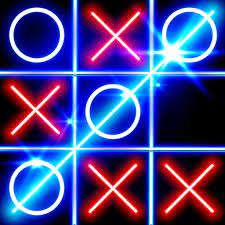

For this tic-tac-toe problem, for each move we make (player 1), the algorithm (player 2) finds the best move to make with MCTS.  MCTS algorithm can handle decision making in the real-time in a limited amount of time.

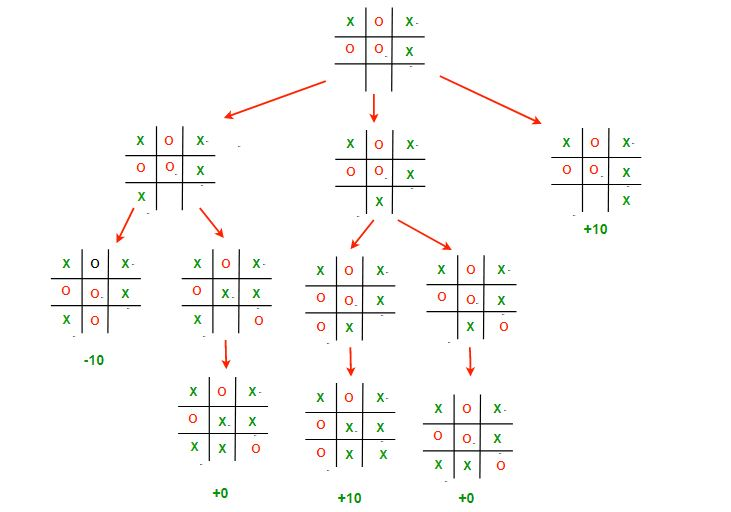

The MCTS is devided into 4 steps:
1. SELECTION : the algorithm starts with a root node and selects a child node such that it picks the node with maximum win rate (each node is given a fair chance). The idea is to keep selecting optimal child nodes until we reach the leaf node of the tree. A good way to select such a child node is to use UCT (Upper Confidence Bound applied to trees) formula.
2. EXPANSION : when it can no longer apply UCT to find the successor node, it expands the game tree by appending all possible states from the leaf node.
3. SIMULATION : the algorithm picks a child node arbitrarily, and it simulates a randomized game from selected node until it reaches the resulting state of the game.
4. BACKPROPAGATION : Once the algorithm reaches the end of the game, it evaluates the state to figure out which player has won. It traverses upwards to the root and increments visit score for all visited nodes. It also updates win score for each node if the player for that position has won the playout.

MCTS keeps repeating these four phases until some fixed number of iterations or some fixed amount of time.

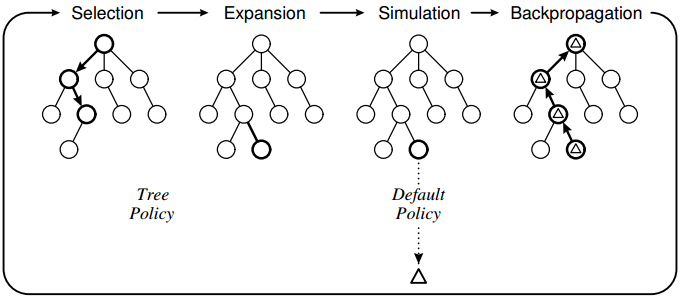

Ways of selection :
- UCT is one prevalent way of deciding what action to take in the exploration&exploitation dilemma in MCTS. 
- AMAF is an improvement of tree policy created by making an assumption about
the ’goodness’ of moves. It assumes that moves that was made during any point
during a simulation that ended in victory are good regardless of when those
move are played. AMAF can be used in conjunction with UCT to more quickly guide
UCT towards possible good moves.
- RAVE is an extension of α-AMAF that changes the α-weights of each node independently.

All Moves As First (AMAF) and its successor Rapid Action Value Estimation (RAVE) are enhancements that have often been proved very successful when applying MCTS to the game of Go [Gelly, 2011]. The basic idea is to update statistics for all actions selected during a simulation as if they were the first action applied. This method is particularly well suited for incremental games such as Go, where the value of a move is often dependent on the state of the board in its close proximity and unaffected by moves played elsewhere on the board. Due to the popularity of AMAF, these methods are mentioned here for completeness but will not be pursued further due to the lack of applicability to Awale where the value of moves are dependent on the whole board and on the advancement of the game.


### Implementation

In [4]:
# Import usefull packages
from abc import ABC, abstractmethod
from collections import defaultdict, namedtuple
from math import *
from random import choice


# Variable with Global scope
RAVE_CONST = 300

# Define MCTS functions
class MCTS_UTC:
    # Define parameters
    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.Q_RAVE = defaultdict(int)  # times this move has been critical in a rollout
        self.N_RAVE = defaultdict(int) # times this move has appeared in a rollout
        self.explo_wg = exploration_weight # parameter to balance exploration & exploitation
    
    # Choose the best move for the game (the next node of the tree)
    def choose_best_move(self, node):
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    # Make the tree one layer after
    def rollout_step(self, node):
        path = self.select(node)
        leaf = path[-1]
        self.expand(leaf)
        reward = self.simulate(leaf)
        self.backup(path, reward)

    # Find an unexplored descendent of `node`
    "add a parameter to choose the way of selection"
    def select(self, node): 
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper 

    # Update the `children` dict with the children of `node`
    def expand(self, node):
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    # Returns the reward for a random simulation of `node`
    def simulate(self, node):
        invert_reward = True
        while True:
            if node.is_terminal():
                reward = node.reward()
                return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    # Send the reward back up to the ancestors of the leaf
    def backup(self, path, reward):
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    # Select a child of node, balancing exploration & exploitation with the UTC method (UTC = Upper confidence bound for trees)
    def _uct_select(self, node):
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_parent = log(self.N[node])

        def uct(n):
            return self.Q[n] / self.N[n] + self.explo_wg * sqrt(
                log_N_parent / self.N[n])   # exploitation + exploration

        return max(self.children[node], key=uct)


    # Select a child of node, balancing exploration & exploitation with the UTC-RAVE method
    "Not working properly"
    def _UTC_rave_select(self, node):
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_parent = log(self.N[node])

        def UTC_rave(n):
            # A definir
            alpha = max(0, (RAVE_CONST - self.N[n])/ RAVE_CONST)
            UCT = self.Q[n] / self.N[n] + self.explo_wg * sqrt(
                log_N_parent / self.N[n])
            AMAF = self.Q_RAVE / self.N_RAVE if self.N_RAVE is not 0 else 0
            return (1 - alpha) * UCT + alpha * AMAF

        return max(self.children[node], key=UTC_rave)


# Representation of a single board state
class Node(ABC):

    # All possible successors of this board state
    @abstractmethod
    def find_children(self):
        return set()

    # Random successor of this board state (for more efficient simulation)
    @abstractmethod
    def find_random_child(self):
        return None

    # Returns True if the node has no children
    @abstractmethod
    def is_terminal(self):
        return True

    # Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc
    @abstractmethod
    def reward(self):
        return 0

    # Nodes must be hashable
    @abstractmethod
    def __hash__(self):
        return 123456789

    # Nodes must be comparable
    @abstractmethod
    def __eq__(node1, node2):
        return True



# Define the board and its function
tictactoe_tuple = namedtuple("TicTacToe_BOARD", "tup turn winner terminal")

class TicTacToe_BOARD(tictactoe_tuple, Node):
    def find_children(board):
        if board.terminal:  # If the game is finished then no moves can be made
            return set()
        # Otherwise, you can make a move in each of the empty spots
        return {
            board.make_move(i) for i, value in enumerate(board.tup) if value is None
        }

    def find_random_child(board):
        if board.terminal:
            return None  # If the game is finished then no moves can be made
        empty_spots = [i for i, value in enumerate(board.tup) if value is None]
        return board.make_move(choice(empty_spots))

    def reward(board):
        if not board.terminal:
            raise RuntimeError(f"reward called on nonterminal board {board}")
        if board.winner is board.turn:
            # It's your turn and you've already won. Should be impossible.
            raise RuntimeError(f"reward called on unreachable board {board}")
        if board.turn is (not board.winner):
            return 0  # Your opponent has just won. Bad.
        if board.winner is None:
            return 0.5  # Board is a tie
        # The winner is neither True, False, nor None
        raise RuntimeError(f"board has unknown winner type {board.winner}")

    def is_terminal(board):
        return board.terminal

    def make_move(board, index):
        tup = board.tup[:index] + (board.turn,) + board.tup[index + 1 :]
        turn = not board.turn
        winner = search_winner(tup)
        is_terminal = (winner is not None) or not any(v is None for v in tup)
        return TicTacToe_BOARD(tup, turn, winner, is_terminal)

    def to_pretty_string(board):
        to_char = lambda v: ("X" if v is True else ("O" if v is False else " "))
        rows = [
            [to_char(board.tup[3 * row + col]) for col in range(3)] for row in range(3)
        ]
        return (
            "\n  1 2 3\n"
            + "\n".join(str(i + 1) + " " + " ".join(row) for i, row in enumerate(rows))
            + "\n")
        

# Define the game and its functions
def play_game():
    tree = MCTS_UTC()
    board = new_tic_tac_toe_board()
    print(board.to_pretty_string())
    while True:
        row_col = input("enter row,col: ")
        row, col = map(int, row_col.split(","))
        index = 3 * (row - 1) + (col - 1)
        if board.tup[index] is not None:
            raise RuntimeError("Invalid move")
        board = board.make_move(index)
        print(board.to_pretty_string())
        if board.terminal:
            break

        # You can train as you go, or only at the beginning.
        # Here, we train as we go, doing fifty rollouts each turn.
        for _ in range(50):
            tree.rollout_step(board)
        board = tree.choose_best_move(board)
        print(board.to_pretty_string())
        if board.terminal:
            break


def winning_combos():

    for start in range(0, 9, 3):  # three in a row
        yield (start, start + 1, start + 2)
    for start in range(3):  # three in a column
        yield (start, start + 3, start + 6)
    yield (0, 4, 8)  # down-right diagonal
    yield (2, 4, 6)  # down-left diagonal


def search_winner(tup):
    "Returns None if no winner, True if X wins, False if O wins"
    for i1, i2, i3 in winning_combos():
        v1, v2, v3 = tup[i1], tup[i2], tup[i3]
        if False is v1 is v2 is v3:
            return False
        if True is v1 is v2 is v3:
            return True
    return None

# Complete the board with the new move
def new_tic_tac_toe_board():
    return TicTacToe_BOARD(tup=(None,) * 9, turn=True, winner=None, terminal=False)

In [5]:
# Lunch the game (the adversory is the computer and is using MCTS to find the best move with UTC method)
if __name__ == "__main__":
    play_game()


  1 2 3
1      
2      
3      

enter row,col: 1,2

  1 2 3
1   X  
2      
3      


  1 2 3
1   X  
2      
3 O    

enter row,col: 2,2

  1 2 3
1   X  
2   X  
3 O    


  1 2 3
1   X  
2   X  
3 O O  

enter row,col: 3,3

  1 2 3
1   X  
2   X  
3 O O X


  1 2 3
1 O X  
2   X  
3 O O X

enter row,col: 2,1

  1 2 3
1 O X  
2 X X  
3 O O X


  1 2 3
1 O X  
2 X X O
3 O O X

enter row,col: 1,3

  1 2 3
1 O X X
2 X X O
3 O O X



### References
- Cazenave, Tristan. “Evolving Monte-Carlo Tree Search Algorithms.” (2007).
- Browne, Cameron et al. “A Survey of Monte Carlo Tree Search Methods.” IEEE Transactions on Computational Intelligence and AI in Games 4 (2012): 1-43.
- Ameneyro, Fred Valdez et al. “Playing Carcassonne with Monte Carlo Tree Search.” 2020 IEEE Symposium Series on Computational Intelligence (SSCI) (2020): 2343-2350.